### Introduction

This script provides a comprehensive pipeline for managing and processing image datasets with a focus on image dehazing tasks. It encompasses several stages, starting from importing essential libraries to defining and applying deep learning models, and ultimately saving the refined results.

**Library Imports and Setup**  
The script begins by importing a variety of libraries crucial for different aspects of the workflow. Libraries such as `os`, `time`, `h5py`, and `cv2` are used for file operations, time tracking, HDF5 file manipulation, and image processing. For numerical computations and data visualization, it utilizes `numpy`, `matplotlib.pyplot`, and `skimage`. The `keras` library is employed for constructing and training deep learning models, including components for building convolutional neural networks and other layers necessary for image processing tasks.

**Dataset Loading and Processing**  
The `load_train_dataset` function is responsible for loading and processing the NYU Depth V2 dataset. This dataset consists of clear images and their corresponding haze images. The function normalizes the images and extracts patches of a specified size from them. To simulate varying levels of haze, random transmission values are introduced, resulting in a dataset that includes both clean and hazy image patches.

**Dataset Creation and Storage**  
The `create_train_dataset` function manages the creation and storage of the processed dataset. It takes the processed image data and saves it into an HDF5 file format, which supports efficient storage and retrieval of large datasets. This function allows for specifying various parameters such as the number of examples, patch counts, and compression settings to ensure that the dataset is both space-efficient and quickly accessible.

**Dataset Verification and Visualization**  
After creating the dataset, the script verifies its contents by opening the HDF5 file and inspecting its datasets. Sample images from the dataset are displayed using `matplotlib` to confirm that the data has been correctly processed and saved.

**Model Definition and Application**  
The script also includes functions for defining and applying a deep learning model designed for refining transmission maps. The `TransmissionModel` function constructs a convolutional neural network that processes hazy images and predicts refined transmission maps. The Guided Filter function is used to further refine these transmission maps based on grayscale images. The `TransmissionRefine` function enhances the transmission maps predicted by the model.

**Results and Final Output**  
Finally, the trained model is used to predict transmission maps for the hazy images, which are then refined and visualized. The results, including the refined transmission maps and the original images, are saved into a new HDF5 file for future use.


In [70]:
import os, time, h5py, random, cv2
import numpy as np

from PIL import Image
from scipy.io import savemat

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from skimage.transform import resize
from sklearn.feature_extraction import image as skimg

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

The `create_mat_file_from_images` function is designed to process a directory of images and save them into a `.mat` file format, which is commonly used for storing arrays and data in MATLAB. The function takes three parameters: `image_dir`, which is the path to the directory containing the images; `output_file`, which specifies where the resulting `.mat` file will be saved; and `img_size`, a tuple that sets the width and height to which each image will be resized.

The function first lists all files in the specified directory, filtering to include only actual files and sorting them to maintain order. It then processes each image by opening it and resizing it to the dimensions specified by `img_size`. The resized image is converted into a numpy array and normalized by dividing pixel values by 255.0, ensuring that the pixel values are in the range [0, 1]. This normalization is essential for consistency, particularly for tasks involving machine learning.

After processing all the images, the function aggregates these image arrays into a single numpy array. This array is then saved into a `.mat` file using the `savemat()` function from the `scipy.io` module. The image data is stored under the variable name `'images'` in the `.mat` file, making it accessible for future use.

Finally, the function prints a message confirming that the images have been successfully saved and specifies the location of the `.mat` file. This code is useful for preparing image data by ensuring consistency in image size and normalization before further processing or analysis.

In [71]:
def create_mat_file_from_images(image_dir, output_file, img_size=(256, 256)):
    """
    Generate a .mat file from a directory of images.
    
    Parameters:
        image_dir (str): Path to the directory containing the images.
        output_file (str): Path where the .mat file will be saved.
        img_size (tuple): Desired size for resizing images (width, height).
    """
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    image_files.sort()  # Optional: sort filenames if needed
    
    images = []
    
    for img_file in image_files:
        # Open image file
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        
        # Resize image if needed
        img = img.resize(img_size)
        
        # Convert image to numpy array and normalize
        img_array = np.array(img).astype(np.float32) / 255.0
        
        images.append(img_array)
    
    # Convert list of image arrays to a numpy array
    images_np = np.array(images)
    
    # Save to .mat file
    savemat(output_file, {'images': images_np})
    print(f"Saved images to {output_file}")

# Example usage
image_directory = './test'
output_mat_file = './tesImage.mat'
create_mat_file_from_images(image_directory, output_mat_file)


Saved images to ./tesImage.mat


The `load_train_dataset` function is a Python script designed to process the NYU Depth V2 dataset by loading a subset of the data, preprocessing it, and generating image patches for training purposes. The function starts by defining default values for the number of images (`count`) and the number of patches per image (`patch_count`). It then specifies the path to the dataset file, `nyu_depth_v2_labeled.mat`, and opens it in read mode using the `h5py` library.

The function initializes three variables: `nyu_image_patches`, `nyu_haze_patches`, and `nyu_random_transmission`, which will store the extracted image patches, the hazy versions of those patches, and the transmission values used to create the haze effect, respectively. A list of possible transmission values is defined, which will be used later to simulate haze.

In the main loop, the function processes each image in the dataset up to the specified count. For each image, it extracts patches of size 16x16 pixels, normalizes the pixel values to be between 0 and 1, and appends these patches to `nyu_image_patches`. 

After extracting all the patches, the function enters a second loop where it applies a haze effect to each patch. It does this by randomly selecting a transmission value from the predefined list and using it to modify the patch's pixel values, simulating the effect of haze. The modified patches are then stored in `nyu_haze_patches`, and the corresponding transmission values are recorded in `nyu_random_transmission`.

Finally, the function closes the dataset file and returns a dictionary containing three keys: "clear_image_patch", "transmission_values", and "haze_image_patch". These keys correspond to the clear image patches, the random transmission values, and the hazy image patches, respectively. This returned dictionary can be used for training machine learning models that deal with image dehazing or similar tasks.

In [72]:
# Function to Load train dataset from NYU2 Dataset
def load_train_dataset(count = 20, patch_count = 10):
    dataset = './temp/nyu_depth_v2_labeled.mat'
    train_dataset = h5py.File(dataset, "r")

    # Divide image matrix by 255.0 and depth matrix by 4.0 to bring values between 0-1
    trans_vals = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]

    nyu_image_patches       = None
    nyu_haze_patches        = None
    nyu_random_transmission = []

    for i in range(count):
        image = train_dataset['images'][i]
        image = (image.transpose(2,1,0))/255.0
        patches = skimg.extract_patches_2d(image, (16, 16), max_patches=patch_count)
        if nyu_image_patches is not None:
            nyu_image_patches = np.concatenate((nyu_image_patches,patches))
        else:
            nyu_image_patches = patches
        
    
    for image in nyu_image_patches:
        transmission = random.choice(trans_vals)
        image = image*transmission+(1-transmission)
        nyu_random_transmission.append(transmission)
        if nyu_haze_patches is not None:
            nyu_haze_patches = np.concatenate((nyu_haze_patches, [image]))
        else:
            nyu_haze_patches = np.array([image])

    train_dataset.close()

    return {"clear_image_patch":nyu_image_patches, "transmission_values":nyu_random_transmission, "haze_image_patch":nyu_haze_patches}

# d = load_train_dataset()
# print(d)

The provided code defines a function `create_train_dataset` that is designed to create a training dataset, save it to an HDF5 file, and measure the time taken for these operations. The function accepts parameters `count`, `patch_count`, `comp`, and `shuff`, which default to 20, 10, 9, and `True` respectively. When called, the function first records the current time to measure how long it takes to load the training dataset. It then calls `load_train_dataset` with the specified `count` and `patch_count`, storing the returned dictionary in variable `d`. The elapsed time for this operation is calculated and printed, indicating how long it took to create the dictionary. 

Next, the function records the current time again to measure the time taken to create the HDF5 file. It opens a new HDF5 file named `train_data.hdf5` in write mode using the `h5py.File` function and creates three datasets within this file: `clear_image_patch`, `transmission_value`, and `haze_image`, all of which are populated with the corresponding data from the dictionary `d`. Each dataset is created with the specified compression level (`comp`) and shuffling (`shuff`). After creating the datasets, the HDF5 file is closed. The elapsed time for creating and saving the datasets is calculated and printed, along with the compression type, compression options, shuffle setting, and the size of the HDF5 file. The function concludes by printing a confirmation that the dataset has been created.

In summary, this function efficiently measures and reports the time taken to load data and save it into an HDF5 file, while also providing details about the dataset creation process and the resulting file's properties. Finally, the function is called with default values for `count` and `patch_count`, initiating the dataset creation process.

In [76]:
def create_train_dataset(count = 20, patch_count = 10, comp = 9, shuff = True):
    start_time = time.time()
    d = load_train_dataset(count, patch_count)
    elapsed_time = time.time() - start_time
    
    print("--- {:.2f} seconds in creating dictionary ---".format(elapsed_time))
    print("Dictionary created")

    start_time = time.time()
    train_dataset = h5py.File("./temp/train_data.hdf5", "w")
    dset = train_dataset.create_dataset("clear_image",data = d["clear_image_patch"],compression=comp,shuffle=shuff)
    dset = train_dataset.create_dataset("transmission_value",data = d["transmission_values"],compression=comp,shuffle=shuff)
    dset = train_dataset.create_dataset("haze_image",data = d["haze_image_patch"],compression=comp,shuffle=shuff)
    train_dataset.close()
    elapsed_time = time.time() - start_time
    
    print("--- {:.2f} seconds in creating dictionary ---".format(elapsed_time))
    print("compression:",dset.compression," compression_opt:",dset.compression_opts," shuffle:",dset.shuffle," size:",os.stat("./temp/train_data.hdf5").st_size)
    print("Dataset created")  
    return 

     
create_train_dataset(count = 20, patch_count = 10)

--- 0.27 seconds in creating dictionary ---
Dictionary created
--- 0.09 seconds in creating dictionary ---
compression: gzip  compression_opt: 9  shuffle: True  size: 947491
Dataset created


## Checking created Dataset

The provided code demonstrates how to read and visualize data from an HDF5 file named train_data.hdf5 using the h5py library in Python. The code performs several steps to achieve this.

First, the HDF5 file is opened in read mode by calling h5py.File with the file path and the mode 'r'. The resulting file object is stored in the variable temp. To inspect the contents of the file, the code prints the keys of the HDF5 file using temp.keys(), which returns a list-like object containing the names of the datasets stored within the file.

Next, the code uses Matplotlib's plt.imshow function to visualize specific entries from the clear_image and haze_image datasets. It selects the 8th entry from each dataset by indexing with [8] and displays these images in separate figures using plt.show(). The images will appear one after the other, allowing you to compare the clear image with its corresponding hazy version.

Following the image displays, the code prints the 1000th entry from the transmission_value dataset using print(temp['transmission_value'][8]). This shows the transmission value associated with the 8th image, which is likely a numerical value or an array of values that provide additional information about the image.

To understand the overall structure and size of the datasets, the code prints the shapes of the clear_image and haze_image datasets, along with the length of the transmission_value dataset. It uses temp['clear_image'].shape, temp['haze_image'].shape, and len(temp['transmission_value']) to obtain and print this information. The shapes of the image datasets give you the dimensions of the images and the number of images, while the length of the transmission_value dataset provides the number of transmission values stored.

Finally, the code closes the HDF5 file using temp.close(), ensuring that all resources associated with the file are properly released. This step is important to prevent memory leaks and to ensure that the file is not left in an open state, which could cause issues if the file needs to be accessed again later.

Overall, this code snippet provides a clear example of how to open an HDF5 file, inspect its contents, visualize specific data entries, and print out important information about the datasets stored within the file.

<KeysViewHDF5 ['clear_image', 'haze_image', 'transmission_value']>


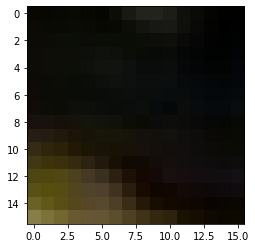

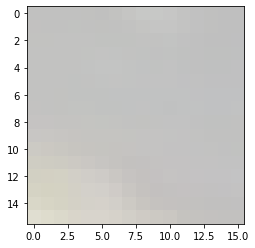

0.25
(200, 16, 16, 3) (200, 16, 16, 3) 200


In [77]:
temp = h5py.File('./temp/train_data.hdf5', 'r')
print(temp.keys())
plt.imshow(temp['clear_image'][8])
plt.show()
plt.imshow(temp['haze_image'][8])
plt.show()
print(temp['transmission_value'][8])
print(temp['clear_image'].shape,temp['haze_image'].shape,len(temp['transmission_value']))
temp.close()
     
    
!cp './temp/train_data.hdf5' './Project/Datasets/TrainData/train_data_patch_16x16.hdf5'

The code begins by importing the necessary modules from TensorFlow, specifically Keras components, which are essential for defining and working with neural networks. The `TransmissionModel` function is then defined, taking `input_shape` as its argument, which specifies the shape of the images in the dataset excluding the batch dimension. The function starts by creating an input layer with the specified shape, named 'input1'.

Following this, the input layer is passed through a convolutional layer (`Conv2D`) with 16 filters of size 3x3 and stride of 1x1. The output of this convolutional layer is then activated using the ReLU function to introduce non-linearity into the model. This activated output is subsequently sliced into four equal parts along the last dimension using `Lambda` layers, each named 'slice1', 'slice2', 'slice3', and 'slice4'. These slices are then recombined using a `Maximum` layer named 'merge1_maximum', which takes the maximum value at each position across the slices.

The model then applies three parallel convolutional layers, each with 16 filters but with different kernel sizes (3x3, 5x5, and 7x7), to capture multi-scale features. These layers operate on the output from the previous `Maximum` layer. The outputs of these three convolutional layers are then concatenated along the last dimension using a `Concatenate` layer named 'merge2_concatenate'. This concatenation combines the features learned at different scales into a single tensor.

Next, a `MaxPooling2D` layer with a pool size of 7x7 and a stride of 1x1 is applied to reduce the spatial dimensions of the concatenated output while retaining the most significant features. The pooled output is then passed through another convolutional layer with a single filter of size 8x8 and a stride of 1x1, followed by another ReLU activation, providing the final processed output of the model.

An instance of the model is created using the input layer and the final output layer, with the model named 'TransmissionModel'. The function then returns this model instance.

After defining the model function, the input shape is specified as (64, 64, 16), representing images with height and width of 64 pixels and 16 channels. The `TransmissionModel` function is called with this input shape to create the model. The model's architecture is printed to the console using the `model.summary()` method, providing a detailed summary of each layer, its output shape, and the number of parameters.

To simulate the model, random input data is generated with the specified shape, using a batch size of 1. This random data is passed through the model using the `model.predict()` method, and the shape of the model's output is printed to verify that the model processes the input data correctly.

In summary, this code defines a complex neural network model designed for transmission image processing, creates an instance of this model with a specific input shape, and simulates the model using random input data to verify its functionality. The model includes convolutional layers, slicing and merging operations, multi-scale feature extraction, and pooling, all combined to process the input images effectively.


# Neural Network Model Explanation using mathmatical model 

The following explanation outlines the mathematical operations involved in the neural network model:

## Convolution Operation

For each pixel in the output feature map, a convolution operation with a kernel (filter) is performed on the input image. The convolution is defined as:

$$ F_i(x, y) = \sum_{k=1}^{3} \sum_{l=1}^{3} K_i(k, l) \cdot X(x+k-1, y+l-1) $$

Here, $K_i$ represents the $i$-th filter, $X$ is the input image, and $F_i$ is the resulting feature map. The filter slides over the input image, applying the kernel weights to compute the feature values.

## Activation Function

After convolution, the ReLU activation function introduces non-linearity:

$$ A_i(x, y) = \max(0, F_i(x, y)) $$

This operation ensures that all negative values are set to zero while positive values remain unchanged, which helps in learning non-linear relationships.

## Slicing Operation

The activated feature map is sliced into segments to separate different parts of the feature dimensions:

$$ X_1 = A(:, :, :, 1:4) $$
$$ X_2 = A(:, :, :, 4:8) $$
$$ X_3 = A(:, :, :, 8:12) $$
$$ X_4 = A(:, :, :, 12:) $$

Each slice $X_j$ captures a subset of the features along the depth dimension.

## Maximum Operation

The maximum function is applied across the slices to retain the most significant features:

$$ M(x, y) = \max(X_1(x, y), X_2(x, y), X_3(x, y), X_4(x, y)) $$

This operation helps in preserving the strongest features from each slice.

## Multi-Scale Convolutional Blocks

Three separate convolutional operations are applied with different kernel sizes to capture features at multiple scales:

$$ C_{3x3}(x, y) = \sum_{k=1}^{3} \sum_{l=1}^{3} W_{3x3}(k, l) \cdot M(x+k-1, y+l-1) $$
$$ C_{5x5}(x, y) = \sum_{k=1}^{5} \sum_{l=1}^{5} W_{5x5}(k, l) \cdot M(x+k-1, y+l-1) $$
$$ C_{7x7}(x, y) = \sum_{k=1}^{7} \sum_{l=1}^{7} W_{7x7}(k, l) \cdot M(x+k-1, y+l-1) $$

Here, $W_{3x3}$, $W_{5x5}$, and $W_{7x7}$ are filters of sizes 3x3, 5x5, and 7x7, respectively. Each filter detects features at different spatial resolutions.

## Concatenation

The outputs from the multi-scale convolutions are concatenated along the depth dimension:

$$ C(x, y) = [C_{3x3}(x, y), C_{5x5}(x, y), C_{7x7}(x, y)] $$

This step merges features detected at various scales into a single feature map.

## Max-Pooling

A max-pooling operation with a $7 \times 7$ filter downsamples the feature map by selecting the maximum value in each pooling region:

$$ P(x, y) = \max_{(i, j) \in [x-3, x+3] \times [y-3, y+3]} C(i, j) $$

This reduces the spatial dimensions while retaining the most significant features.

## Final Convolution and Activation

A final convolution with a single $8 \times 8$ filter is applied, followed by a ReLU activation function:

$$ F_{final}(x, y) = \sum_{k=1}^{8} \sum_{l=1}^{8} W_{final}(k, l) \cdot P(x+k-1, y+l-1) $$
$$ A_{final}(x, y) = \max(0, F_{final}(x, y)) $$

The final convolutional layer refines the features and the ReLU activation introduces non-linearity.

## Summary

The model employs convolutional layers, activation functions, slicing, maximum pooling, and multi-scale feature extraction to process and enhance features from input images. Each step in the model contributes to transforming the input into a meaningful output by applying specific mathematical operations.


In [80]:
def TransmissionModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV Block for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)
    
    # CONV -> RELU Block
    X = Conv2D(1, (8, 8), strides = (1, 1), name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

# Define input shape
input_shape = (64, 64, 16)  # Example input shape, adjust based on your data
model = TransmissionModel(input_shape) # Create the model
model.summary() # Print the model summary

# Simulate with random data
input_data = np.random.rand(1, *input_shape).astype(np.float32)  # Batch size of 1
output_data = model.predict(input_data)

print("Output shape:", output_data.shape)

Model: "TransmissionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 64, 64,    │          0 │ -                 │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 62, 62,    │      2,320 │ input1[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation1         │ (None, 62, 62,    │          0 │ conv1[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice1 (Lambda)     │ (None, 62, 62, 4) │          0 │ activation1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice2 (Lambda)     │ (None, 62, 62, 4) │          0 │ activation1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice3 (Lambda)     │ (None, 62, 62, 4) │          0 │ activation1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice4 (Lambda)     │ (None, 62, 62, 4) │          0 │ activation1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge1_maximum      │ (None, 62, 62, 4) │          0 │ slice1[0][0],     │
│ (Maximum)           │                   │            │ slice2[0][0],     │
│                     │                   │            │ slice3[0][0],     │
│                     │                   │            │ slice4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_3x3 (Conv2D)  │ (None, 62, 62,    │        592 │ merge1_maximum[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_5x5 (Conv2D)  │ (None, 62, 62,    │      1,616 │ merge1_maximum[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_7x7 (Conv2D)  │ (None, 62, 62,    │      3,152 │ merge1_maximum[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge2_concatenate  │ (None, 62, 62,    │          0 │ conv2_3x3[0][0],  │
│ (Concatenate)       │ 48)               │            │ conv2_5x5[0][0],  │
│                     │                   │            │ conv2_7x7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1            │ (None, 56, 56,    │          0 │ merge2_concatena… │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 49, 49, 1) │      3,073 │ maxpool1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation2         │ (None, 49, 49, 1) │          0 │ conv3[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Output shape: (1, 49, 49, 1)


The code implements guided filtering, a technique in image processing that smooths an image while preserving edges and details, using a mathematical model based on local image statistics. The guided filtering process is executed through a series of well-defined steps involving mathematical operations and image statistics.

### Technical and Mathematical Details

The guided filtering operation starts by defining the `Guidedfilter` function, which performs the filtering process. This function uses the guidance image (`im`) and the input image (`p`) to compute the filtered output. The main mathematical operations in the guided filter involve the calculation of local mean and variance, which are essential for determining how the filtering will be applied.

First, the function calculates the local mean of the guidance image and the input image using a box filter. This box filter computes the average pixel value within a square window of radius `r`, centered on each pixel. Mathematically, if $I$ is the guidance image and $p$ is the input image, the local mean of $I$ at each pixel is represented as:

$\text{mean}_I(x, y) = \frac{1}{r^2} \sum_{(x', y') \in \text{window}} I(x', y')$

where $(x, y)$ denotes the pixel location and the sum is taken over all pixels within the window.

The function also computes the local mean of the product of the guidance and input images, as well as the local mean of the square of the guidance image. From these, the covariance between the guidance and the input image and the variance of the guidance image are derived. Specifically, the covariance $\text{cov}_{Ip}$ is:

$\text{cov}_{Ip}(x, y) = \text{mean}_{Ip}(x, y) - \text{mean}_I(x, y) \cdot \text{mean}_p(x, y)$

where $\text{mean}_{Ip}(x, y)$ is the local mean of the product $I \cdot p$.

The variance $\text{var}_I$ is computed as:

$\text{var}_I(x, y) = \text{mean}_{II}(x, y) - (\text{mean}_I(x, y))^2$

where $\text{mean}_{II}(x, y)$ is the local mean of the square of the guidance image.

With the covariance and variance values, the function calculates the linear coefficients $a$ and $b$ for the filtering model. These coefficients are given by:

$a(x, y) = \dfrac{\text{cov}_{Ip}(x, y)}{\text{var}_I(x, y) + \epsilon}$

$b(x, y) = \text{mean}_p(x, y) - a(x, y) \cdot \text{mean}_I(x, y)$

where $\epsilon$ is a small regularization parameter to prevent division by zero and stabilize the computation.

The coefficients $a$ and $b$ are then smoothed using a box filter to produce `mean_a` and `mean_b`, which are used to compute the final output image $q$ as:

$q(x, y) = \text{mean}_a(x, y) \cdot I(x, y) + \text{mean}_b(x, y)$

In the `main` function, a grayscale image is loaded and normalized. Guided filtering is applied with the specified radius `r` and regularization parameter `epsilon`. The `Guidedfilter` function processes the image based on the described mathematical model, producing a filtered image that maintains edge details while smoothing other areas. Finally, both the original and filtered images are displayed for comparison using matplotlib.

This approach ensures that the filtering process not only smooths the input image but also respects the details present in the guidance image, leading to results that preserve important features while reducing noise.

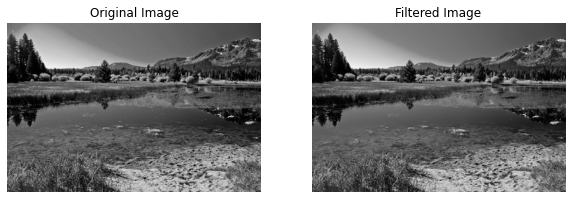

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def Guidedfilter(im, p, r, eps):
    """
    Perform guided filtering on an image.

    Parameters:
    - im: Guidance image (grayscale or one channel of a color image).
    - p: Input image to be filtered.
    - r: Radius of the window.
    - eps: Regularization parameter.

    Returns:
    - q: Output image after guided filtering.
    """
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p
    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I
    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))
    q = mean_a * im + mean_b
    return q

def main():
    # Load a sample image (grayscale)
    image = cv2.imread('./content/Sample_image.jpg', cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found. Make sure 'sample_image.jpg' is in the working directory.")

    # Normalize the image to the range [0, 1]
    image = image.astype(np.float64) / 255.0

    # Parameters for the guided filter
    r = 15
    eps = 1e-3

    # Apply guided filter
    filtered_image = Guidedfilter(image, image, r, eps)

    # Plot the original and filtered images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Filtered Image')
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    main()

# Transmission Map Refinement using Guided Filter

## Overview

The provided code is used for refining a transmission map of an image using a Guided Filter. The process involves two main steps: converting an image to grayscale and normalizing it, followed by refining a transmission map using the Guided Filter.

## Detailed Explanation

### Conversion to Grayscale and Normalization

The function `TransmissionRefine` begins by converting the input color image (`im`) to grayscale. This is achieved using OpenCV's `cv2.cvtColor` function, which changes the image from the BGR color space to grayscale. Each pixel in the grayscale image represents the intensity of light, where the pixel values range from 0 (black) to 255 (white).

After conversion, the grayscale image is normalized by dividing its pixel values by 255. This normalization scales the pixel values to the range $[0, 1]$, which is useful for many image processing algorithms. Mathematically, if $I(x, y)$ represents the grayscale intensity of pixel $(x, y)$, then the normalized intensity $I_{norm}(x, y)$ is given by:

$$ 
I_{norm}(x, y) = \frac{I(x, y)}{255}
$$

### Guided Filter Application

The core of the transmission refinement is the application of the Guided Filter, implemented as `Guidedfilter`. This filter is used to refine the transmission map (`et`). The Guided Filter is a type of edge-preserving smoothing filter that adjusts the transmission map based on the guidance image, which is the normalized grayscale image in this case.

The Guided Filter operates under the assumption that the refined transmission map should be close to the original map but should also smooth out noise and preserve edges. Mathematically, the Guided Filter adjusts each pixel’s value based on its local neighborhood while preserving the edges.

The output $q$ is estimated using the guidance image $I$ and the transmission map $t$. The filter smooths $t$ based on $I$ while minimizing the difference between the output and the input transmission map in a least-squares sense. The refined transmission map $\tilde{t}$ is given by:

$$
\tilde{t}(x, y) = \text{mean}(t(x', y')) + \text{correction}(x, y)
$$

where $(x', y')$ are the neighboring pixels, and the correction term is computed based on the guidance image and the radius $r$, and $\epsilon$ is a regularization parameter that controls the smoothness.

### Visualization

After refining the transmission map, the `main` function visualizes both the original and refined transmission maps. It uses Matplotlib to display the images side by side for comparison.

- The original transmission map (`et`) is displayed in one subplot.
- The refined transmission map, obtained from the `TransmissionRefine` function, is displayed in the adjacent subplot.

The display helps in visually assessing the effectiveness of the refinement process by showing how the Guided Filter has improved the transmission map.

## Summary

In summary, the provided code refines a transmission map of an image using a Guided Filter. It starts by converting the image to grayscale and normalizing it. Then, it applies the Guided Filter to smooth and refine the transmission map while preserving the important features. Finally, it visualizes the results to compare the original and refined maps. The Guided Filter helps in achieving a smoother transmission map while retaining essential edges and features from the guidance image.


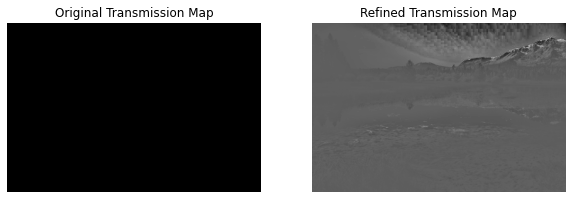

In [81]:
def TransmissionRefine(im, et):
    # Convert image to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255  # Normalize to range [0, 1]
    
    r = 60
    eps = 0.0001
    
    # Apply Guided Filter
    t = Guidedfilter(gray, et, r, eps)
    return t

def main():
    # Load an example image
    image_path = './content/Sample_image.jpg'  # Replace with your image file
    im = cv2.imread(image_path)

    # Create a mock transmission map for demonstration
    # For a real application, this should be obtained from your processing pipeline
    et = np.ones_like(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), dtype=np.float64) / 255

    # Apply the TransmissionRefine function
    refined_transmission = TransmissionRefine(im, et)

    # Display the results
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Transmission Map')
    plt.imshow(et, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Refined Transmission Map')
    plt.imshow(refined_transmission, cmap='gray')
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    main()

The code snippet is designed to load, process, and visualize image data for evaluating a dehazing model. 

It begins by loading an HDF5 file, located at `./Project/Datasets/TrainData/train_data_patch_16x16.hdf5`, which contains datasets of clean images, hazy images, and transmission values. Using the `h5py.File(file, 'r')` command, the file is opened in read mode, and the datasets are accessed and converted into NumPy arrays. The arrays, `clean_image`, `haze_image`, and `transmission_value`, contain the image patches and associated transmission values. The script then prints the number of training examples and the shapes of the clean and hazy image patches to confirm the dimensions and quantity of the data.

Next, a deep learning model, `tm_model`, is instantiated with an input shape of `(31, 31, 3)`, indicating that the model expects images of this size with three color channels. The model's weights are loaded from a specified file path, `./temp/resmodel_150_30_weights.h5`, which contains the trained parameters necessary for making predictions.

The hazy images are then padded symmetrically using `np.pad`, which ensures that the edges of the images are handled properly when processed by the model. This padding compensates for potential edge artifacts and aligns with the model's input requirements. The padded hazy images are fed into the model to predict the transmission maps. These maps are reshaped to match the original size of the image patches.

To enhance the predicted transmission maps, the hazy images are first converted to an 8-bit format by scaling them back from a range of [0, 1] to [0, 255] and changing the data type to `uint8`. Each predicted transmission map is then refined using the `TransmissionRefine` function, which applies a guided filter to improve the accuracy of the transmission maps based on the grayscale version of the hazy images.

Finally, the script visualizes a selection of images to assess the results. It displays ten images in sequence, showing the clean image patches, hazy image patches, the transmission maps predicted by the model, and the refined transmission maps. This visual inspection allows for an evaluation of how well the model and subsequent refinement process perform in generating accurate transmission maps.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shape of nyu_transmission_map: (200, 16, 16, 1)


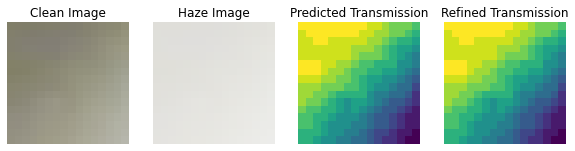

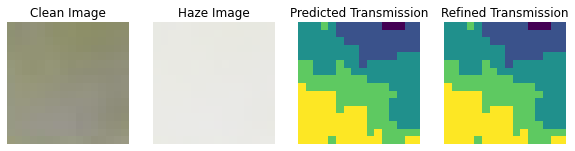

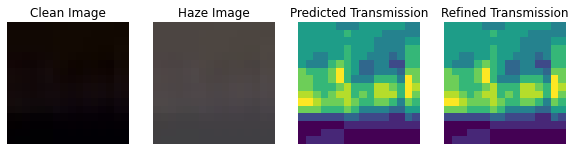

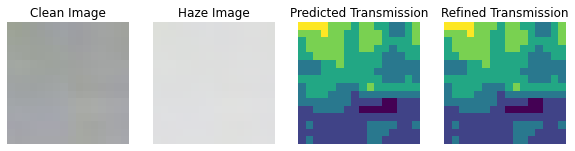

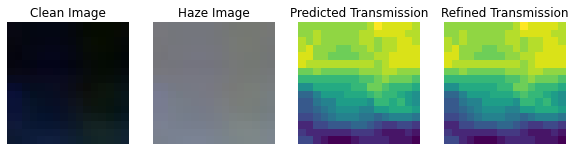

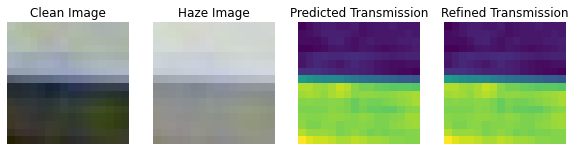

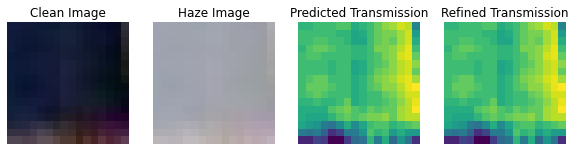

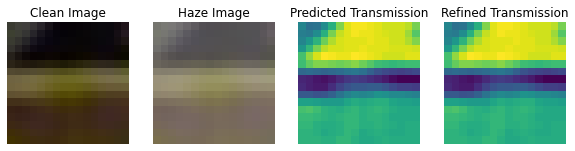

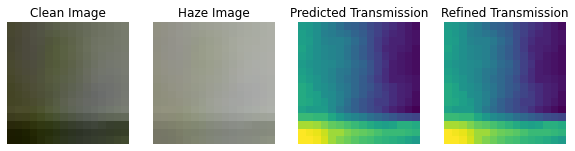

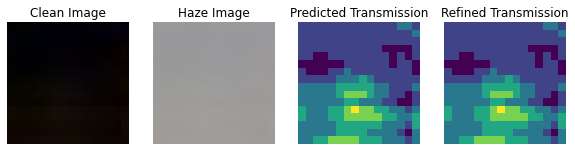

In [82]:
# Define or load the TransmissionModel
tm_model = TransmissionModel((31, 31, 3))  # Ensure this matches the model architecture used for weights

# Load the new weights file
weights_file = './temp/transmodel_250_50.h5'
tm_model.load_weights(weights_file)

# Pad haze image and make predictions
c = np.pad(haze_image, ((0, 0), (7, 8), (7, 8), (0, 0)), 'symmetric')
nyu_transmission_map = tm_model.predict(c)

# Print the shape of nyu_transmission_map to debug
print(f"Shape of nyu_transmission_map: {nyu_transmission_map.shape}")

# Flatten the channel dimension
nyu_transmission_map = np.squeeze(nyu_transmission_map)  # Remove dimensions of size 1

# Verify the shape
num_samples = nyu_transmission_map.shape[0]
if nyu_transmission_map.shape[1:] == (16, 16):
    b = nyu_transmission_map  # No need to reshape if it's already in the correct shape
else:
    raise ValueError(f"Unexpected shape: {nyu_transmission_map.shape}")

# Convert haze image to uint8 and refine transmission map
d = (haze_image * 255.0).astype('uint8')
for i, val in enumerate(b):
    b[i] = TransmissionRefine(d[i], val)

# Assuming 'm' was supposed to be 'nyu_transmission_map' for visualization
m = nyu_transmission_map  # Already in correct shape

# Visualization of the results
for i in range(min(10, num_samples)):  # Ensure the number of samples to visualize does not exceed available data
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(clean_image[i])
    plt.title("Clean Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(haze_image[i])
    plt.title("Haze Image")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(m[i])
    plt.title("Predicted Transmission")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(b[i])
    plt.title("Refined Transmission")
    plt.axis('off')

    plt.show()


The provided code snippet is designed to read and process image data from an HDF5 file using the `h5py` library. HDF5, or Hierarchical Data Format version 5, is a file format that supports the creation, access, and sharing of scientific data. In this code, the HDF5 file located at `./Project/Datasets/TrainData/train_data_patch_16x16.hdf5` is opened in read-only mode. The `h5py.File(file, 'r')` function is used to achieve this, with the resulting `train_dataset` object providing access to the contents of the file.

The code then extracts three specific datasets from the HDF5 file. The first dataset, `clean_image`, is accessed using `train_dataset['clear_image'][:]`, which retrieves the entire dataset of clean, haze-free images into a NumPy array. Similarly, `haze_image` is accessed with `train_dataset['haze_image'][:]`, loading the dataset of hazy images into another NumPy array. The third dataset, `transmission_value`, is accessed using `train_dataset['transmission_value']`, and its contents are converted into a NumPy array as well. This dataset likely contains transmission values associated with the images.

Finally, the code prints out several pieces of information about the datasets. It displays the total number of training examples, which is derived from the first dimension of the `clean_image` array, assuming this array has a shape that includes the number of examples as its first dimension. The shapes of both `clean_image` and `haze_image` arrays are also printed, providing details on their dimensions. For instance, if the `clean_image` array has a shape of `(1000, 16, 16, 3)`, this indicates there are 1000 image patches, each with a size of 16x16 pixels and 3 color channels. Similarly, the shape of the `haze_image` array would give comparable dimensional information. This code is typically used in machine learning and image processing workflows to prepare and inspect data before it is used for training models or performing analysis.

In [62]:
file = './Project/Datasets/TrainData/train_data_patch_16x16.hdf5'
train_dataset = h5py.File(file, 'r')
clean_image = np.array(train_dataset['clear_image'][:])
haze_image = np.array(train_dataset['haze_image'][:])
transmission_value = np.array(train_dataset['transmission_value'])

print ("number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)

number of training examples: 200
Clean Image Patch shape: (200, 16, 16, 3)
Haze Image Patch shape: (200, 16, 16, 3)
